/scratch1/ajoshi/temp_dir/IXI244-Guys-0841_t1.cortex.dewisp.mask.nii.gz


/home1/ajoshi/.local/lib/python3.9/site-packages/nilearn/plotting/find_cuts.py:148: UserWarning: Could not determine cut coords: All voxels were masked by the thresholding. Returning the center of mass instead.
  warnings.warn(


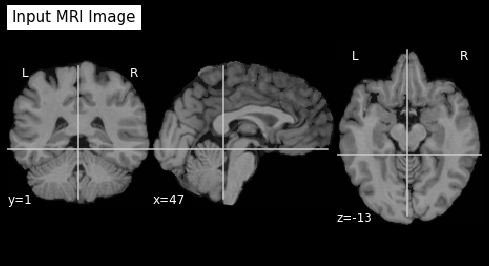

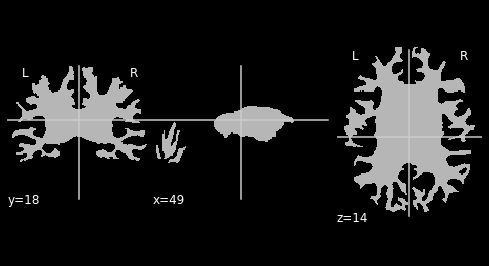

In [1]:
from functools import reduce
from gen_rand_blob import gen_rand_blob_mesh, mesh_to_mask_3d, create_spherical_mask
import plotly.graph_objects as go
from matplotlib import pyplot as plt

from dfsio import readdfs, writedfs
from surfproc import reducepatch
import nibabel as nb
import numpy as np
import os
from nilearn import plotting
from nilearn.image import coord_transform
from scipy.ndimage import gaussian_filter
import numpy as np
from noise import snoise3,pnoise3
from scipy.ndimage import binary_erosion
import shutil


volume_size = (16,16,16)  # size of the lesion volume in voxels

"""
IXI440-HH-2127
IXI441-HH-2154
IXI442-IOP-1041
IXI443-HH-2215
IXI444-HH-2270
IXI445-HH-2269
IXI446-HH-2325
IXI447-Guys-0979
IXI448-HH-2393
IXI449-Guys-1082
IXI450-Guys-1093
IXI451-HH-2212
IXI452-HH-2213
IXI453-HH-2214
IXI454-Guys-1083
IXI455-Guys-0981
IXI456-Guys-1019
IXI457-Guys-0984
IXI458-Guys-0993
IXI459-Guys-0992
IXI460-Guys-0999
IXI461-Guys-0998
IXI462-IOP-1042
IXI463-IOP-1043
"""
#sub_name = 'IXI244-Guys-0841'

sub_name = ''

mri_orig = '/scratch1/akrami/Data_train/Train/ixi/t1/' + sub_name + '_t1.nii.gz'
out_dir = '/scratch1/ajoshi/temp_dir'


mri = os.path.join(out_dir,sub_name + '_t1.nii.gz')

wm_mask = os.path.join(out_dir,sub_name +'_t1.cortex.dewisp.mask.nii.gz')

print(wm_mask)

shutil.copyfile(mri_orig, mri)
cmd = '/project/ajoshi_27/BrainSuite23a/bin/cortical_extraction.sh ' + mri

if not os.path.isfile(wm_mask):
    os.system(cmd)

plotting.plot_anat(mri,title='Input MRI Image')
plotting.plot_anat(wm_mask)


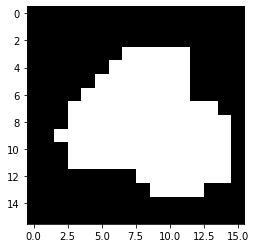

In [2]:

out_lesion_mask = os.path.join(out_dir, sub_name +'.lesion.mask.nii.gz')

out_lesion = os.path.join(out_dir, sub_name +'.lesion.nii.gz')
out_lesion_center = os.path.join(out_dir, sub_name +'.lesion.center.nii.gz')



vertices, faces = gen_rand_blob_mesh(radius=1.0,num_subdivisions=6,scale=0.7)

class m:
    pass

m.faces = faces


vertices = (vertices - vertices.min())/(vertices.max() - vertices.min())
m.vertices = vertices
m=reducepatch(m, .9)
# Create a binary mask from the mesh
binary_mask = mesh_to_mask_3d((volume_size[0])*(m.vertices),volume_size=volume_size)


# Create a Nifti image from the binary mask
nifti_img = nb.Nifti1Image(np.uint16(binary_mask), affine=None)

# Write the Nifti image to disk
nb.save(nifti_img, 'binary_mask.nii.gz')

# Display the binary mask
plt.imshow(binary_mask[:,:,int(volume_size[2]/4)], cmap='gray')
plt.show()

# Plot the mesh using Plotly
fig = go.Figure(data=[go.Mesh3d(x=m.vertices[:, 0], y=m.vertices[:, 1], z=m.vertices[:, 2], i=m.faces[:, 0], j=m.faces[:, 1], k=m.faces[:, 2])])
# Set layout
fig.update_layout(scene=dict(aspectmode="data"))
fig.update_layout(title=f'Icosphere Mesh')
fig.write_image('ico.png')
plt.show()


75906
(16, 16, 16)
(57, 109, 78)
out_lesion_mask


/home1/ajoshi/.local/lib/python3.9/site-packages/nilearn/plotting/find_cuts.py:148: UserWarning:

Could not determine cut coords: All voxels were masked by the thresholding. Returning the center of mass instead.



smoothed_img
254.9999986268124
0.0


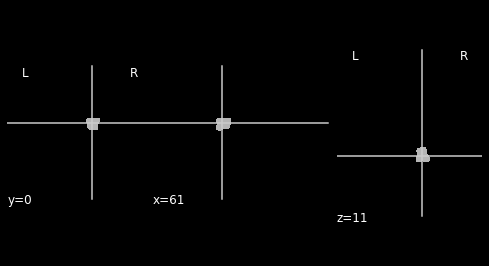

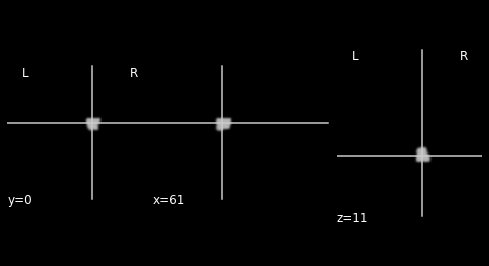

In [3]:

# Load the white matter mask and MRI
v = nb.load(wm_mask).get_fdata().astype(np.uint16)
v_mri = nb.load(mri).get_fdata()
affine = nb.load(mri).affine


v = binary_erosion(v, iterations=int(volume_size[0]/2))

nonzero_indices = np.where(v > 0.1)
random_index = np.random.choice(len(nonzero_indices[0]))
rand_pix_cent = (nonzero_indices[0][random_index], nonzero_indices[1][random_index], nonzero_indices[2][random_index])

print(len(nonzero_indices[0]))
print(volume_size)
print(rand_pix_cent)

v_mri = np.zeros_like(v_mri)
v_mri[(rand_pix_cent[0]-int(volume_size[0]/2)):(rand_pix_cent[0]+int(volume_size[0]/2)), (rand_pix_cent[1]-int(volume_size[1]/2)):(rand_pix_cent[1]+int(volume_size[1]/2)), (rand_pix_cent[2]-int(volume_size[2]/2)):(rand_pix_cent[2]+int(volume_size[2]/2))] +=  255*binary_mask.astype(np.uint16) #(1-0.6*binary_mask.astype(np.float64))

nifti_img = nb.Nifti1Image(np.uint16(v_mri), affine=affine).to_filename(out_lesion_mask)




# Voxel coordinates
voxel_coords = (rand_pix_cent[0], rand_pix_cent[1], rand_pix_cent[2])

# Convert voxel coordinates to world coordinates
world_coords = coord_transform(voxel_coords[0],voxel_coords[1],voxel_coords[2], affine)

# Read the Nifti image
lesion_img = nb.load(out_lesion_mask)

# Get the data array
lesion_data = lesion_img.get_fdata()

# Apply 3D Gaussian smoothing
smoothed_data = gaussian_filter(lesion_data, sigma=1)

# Create a new Nifti image with the smoothed data
smoothed_img = nb.Nifti1Image(smoothed_data, affine=lesion_img.affine)

# Write the smoothed image to disk
smoothed_img.to_filename('smoothed_lesion_mask.nii.gz')

print('out_lesion_mask')
plotting.plot_anat(out_lesion_mask)
print('smoothed_img')
plotting.plot_anat(smoothed_img)


# Get the shape of the out_lesion_mask
mask_shape = nb.load(out_lesion_mask).shape

# Generate Perlin noise with the same shape as the mask
perlin_noise = np.zeros(mask_shape)
for i in range(mask_shape[0]):
    for j in range(mask_shape[1]):
        for k in range(mask_shape[2]):
            perlin_noise[i, j, k] = snoise3(i*.1, j*.1, k*.1)

# Normalize the Perlin noise to the range [0, 1]
perlin_noise = (perlin_noise - perlin_noise.min()) / (perlin_noise.max() - perlin_noise.min())


print(smoothed_data.max())
print(smoothed_data.min())


1060.622802734375
-7.462175369262695
1.0
0.0


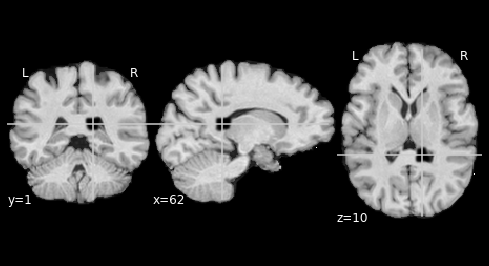

In [4]:


v_mri = nb.load(mri).get_fdata()

v_mri *= (1.0/255)*(255-smoothed_data)
nifti_img = nb.Nifti1Image(np.uint16(v_mri), affine=affine).to_filename(out_lesion)
plotting.plot_anat(out_lesion, cut_coords=world_coords,vmax=1005,vmin=0)


print(v_mri.max())
print(v_mri.min())

print(perlin_noise.max())
print(perlin_noise.min())

In [5]:
print(smoothed_data.max())
print(smoothed_data.min())


254.9999986268124
0.0


/home1/ajoshi/.local/lib/python3.9/site-packages/nilearn/plotting/img_plotting.py:608: UserWarning:

Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.



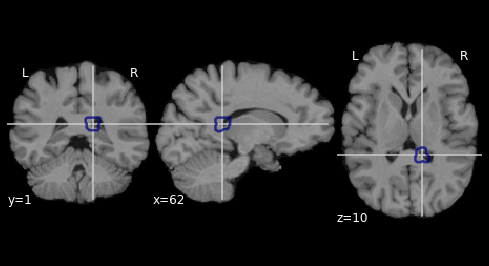

(62.0, 1.0, 10.0)


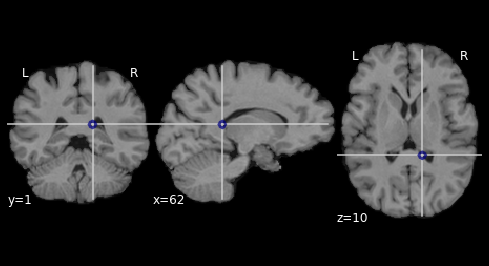

In [6]:

plotting.plot_roi(out_lesion_mask,bg_img=mri, view_type="contours", cmap='jet',vmax=2500, cut_coords=world_coords)
plotting.show()
print(world_coords)


create_spherical_mask(out_lesion_mask, center=voxel_coords, radius=3, output_path=out_lesion_center)

plotting.plot_roi(out_lesion_center,bg_img=mri, view_type="contours", cmap='jet',vmax=2500, cut_coords=world_coords)


In [7]:
import os
from myutils import (
    smooth_3d_segmentation_mask,
    random_lesion_segmentation_carc,
    random_normal_subject_carc,
)

from nilearn.plotting import plot_roi, plot_anat
import nilearn.image as ni



pre_lesion1 = out_lesion_center
post_lesion1 = out_lesion_mask
random_normal_t1 = mri
t1_mask_data =mri
random_normal_subject_mask = mri

pre_lesion = os.path.join(
    out_dir, sub_name + "_pre_lesion.mask.nii.gz"
)
post_lesion = os.path.join(
    out_dir, sub_name + "_post_lesion.mask.nii.gz"
)


v = nb.load(out_lesion_center)
v = nb.Nifti1Image(np.uint16(v.get_fdata()<1), affine=v.affine)
v.to_filename(pre_lesion)

v = nb.load(out_lesion_mask)
nb.Nifti1Image(np.uint16(v.get_fdata()<1), affine=v.affine).to_filename(post_lesion)



In [8]:
pre_lesion = out_lesion_center
post_lesion = out_lesion_mask


pre_lesion_smoothed = os.path.join(
    out_dir, sub_name + "_pre_lesion_smoothed.mask.nii.gz"
)
post_lesion_smoothed = os.path.join(
    out_dir, sub_name + "_post_lesion_smoothed.mask.nii.gz"
)

os.system('cp '+pre_lesion +' '+pre_lesion_smoothed)
os.system('cp '+post_lesion +' '+post_lesion_smoothed)



0

In [9]:

#smooth_3d_segmentation_mask(pre_lesion, pre_lesion_smoothed, iterations=3)
#smooth_3d_segmentation_mask(pre_lesion, pre_lesion_smoothed, iterations=1)

#smooth_3d_segmentation_mask(post_lesion, post_lesion_smoothed, iterations=3)
#smooth_3d_segmentation_mask(post_lesion, post_lesion_smoothed, iterations=1)

p = plot_roi(
    roi_img=pre_lesion_smoothed,
    bg_img=random_normal_t1,
    vmax=1,
    vmin=0,
    title="Random lesion segmentation on random normal subject t1",
)
p.savefig(os.path.join(out_dir, sub_name + "_pre_lesion_smoothed.mask.png"))
cut_coords = p.cut_coords.copy()
p.close()

p2 = plot_roi(
    roi_img=post_lesion_smoothed,
    bg_img=random_normal_t1,
    cut_coords=cut_coords,
    vmax=1,
    vmin=0,
    title="Random lesion segmentation on random normal subject t1",
)
p2.savefig(os.path.join(out_dir, sub_name + "_post_lesion_smoothed.mask.png"))
p2.close()


# create pre and post lesion masks for registration
pre = ni.load_img(pre_lesion_smoothed).get_fdata()
post = ni.load_img(post_lesion_smoothed).get_fdata()
t1_mask_data = ni.load_img(random_normal_subject_mask).get_fdata()
pre_lesion_mask = np.uint16((t1_mask_data > 0.1) & (pre < 0.5))
post_lesion_mask = np.uint16((t1_mask_data > 0.1) & (post < 0.5))

pre_lesion = os.path.join(out_dir, sub_name + "_pre_lesion.mask.nii.gz")
post_lesion = os.path.join(out_dir, sub_name + "_post_lesion.mask.nii.gz")

ni.new_img_like(random_normal_t1, pre_lesion_mask).to_filename(pre_lesion)
ni.new_img_like(random_normal_t1, post_lesion_mask).to_filename(post_lesion)


p = plot_roi(
    roi_img=pre_lesion,
    bg_img=random_normal_t1,
    vmax=1,
    vmin=0,
    cut_coords=cut_coords,
    title="Random lesion segmentation on random normal subject t1",
)
p.savefig(os.path.join(out_dir, sub_name + "_pre_lesion.mask.png"))
p.close()

p2 = plot_roi(
    roi_img=post_lesion,
    bg_img=random_normal_t1,
    vmax=1,
    vmin=0,
    cut_coords=cut_coords,
    title="Random lesion segmentation on random normal subject t1",
)
p2.savefig(os.path.join(out_dir, sub_name + "_post_lesion.mask.png"))
p2.close()


# Do the registration now

from warper_incompressible import Warper


pre2post_lesion = os.path.join(out_dir, sub_name + "_pre2post_lesion.mask.nii.gz")
ddf = os.path.join(out_dir, sub_name + "_pre2post_lesion_ddf.mask.nii.gz")
jac_file = os.path.join(out_dir, sub_name + "_pre2post_lesion_jac.mask.nii.gz")


if 1: #not os.path.isfile(pre2post_lesion):
    nonlin_reg = Warper()
    nonlin_reg.nonlinear_reg(
        target_file=post_lesion,
        moving_file=pre_lesion,
        output_file=pre2post_lesion,
        ddf_file=ddf,
        reg_penalty=1e-3,
        nn_input_size=64,
        lr=1e-3,
        max_epochs=3000,
        loss="mse",
        jacobian_determinant_file=jac_file,
    )



/home1/ajoshi/.local/lib/python3.9/site-packages/monai/networks/blocks/warp.py:72: UserWarning:

monai.networks.blocks.Warp: Using PyTorch native grid_sample.



optimizing
finished  3000  epochs93m 0.02, 0.02  



computing deformation field
applying warp
saving warped output: /scratch1/ajoshi/temp_dir/IXI244-Guys-0841_pre2post_lesion.mask.nii.gz
saving ddf: /scratch1/ajoshi/temp_dir/IXI244-Guys-0841_pre2post_lesion_ddf.mask.nii.gz


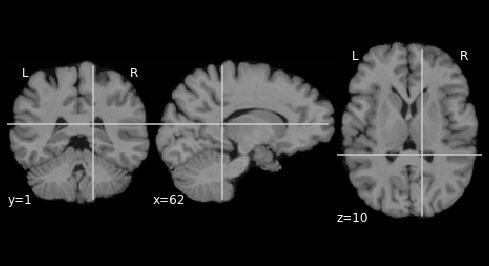

In [10]:

# Modify intensity at the lesion core and then trabsform that

from warp_utils import apply_warp
from monai.transforms import LoadImage, EnsureChannelFirst

t1 = ni.load_img(random_normal_t1).get_fdata()
pre_lesion = ni.load_img(pre_lesion).get_fdata()
pre_lesion = np.uint16(pre > 0.5)
t1_avg = np.mean(t1[pre > 0.5])
t1[pre > 0.5] = t1_avg
t1 = ni.new_img_like(random_normal_t1, t1)

t1_with_pre_lesion = os.path.join(out_dir, sub_name + "_t1_with_pre_lesion.nii.gz")
t1.to_filename(t1_with_pre_lesion)

plotting.plot_anat(t1_with_pre_lesion, cut_coords=world_coords)


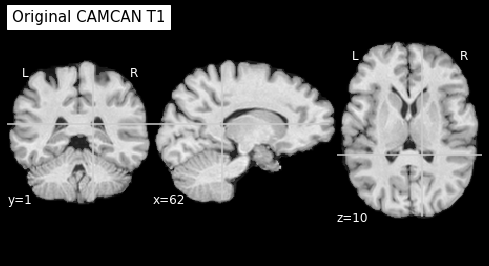

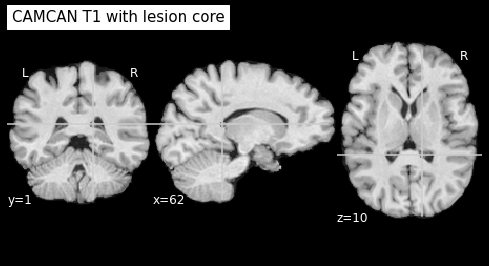

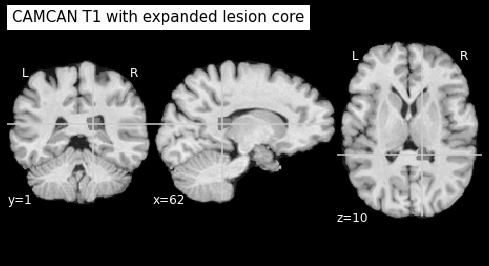

In [11]:
# apply the ddf to the t1 image

moving = LoadImage(image_only=True)(t1_with_pre_lesion)
moving = EnsureChannelFirst()(moving)[None]
target = LoadImage(image_only=True)(t1_with_pre_lesion)
target = EnsureChannelFirst()(target)[None]
ddf = LoadImage(image_only=True)(ddf)
ddf = EnsureChannelFirst()(ddf)[None]

moved = apply_warp(moving_image=moving, disp_field=ddf, target_image=target)

moved_ti_file = os.path.join(out_dir, sub_name + "_lesion_final_t1.nii.gz")

original_t1 = os.path.join(out_dir, sub_name + "_original_t1.nii.gz")

os.system(f"cp {random_normal_t1} {original_t1}")



import nibabel as nb

nb.save(
    nb.Nifti1Image(
        moved[0, 0].detach().cpu().numpy(), ni.load_img(random_normal_t1).affine
    ),
    moved_ti_file,
)


p = plot_roi(
    roi_img=post_lesion,
    bg_img=moved_ti_file,
    vmax=1,
    vmin=0,
    cut_coords=cut_coords,
    title="Random lesion segmentation on random normal subject t1",
)
p.savefig(os.path.join(out_dir, sub_name + "_pre2post_lesion_moved.mask.png"))
p.close()

plot_anat(random_normal_t1, cut_coords=cut_coords, title="Original CAMCAN T1",output_file=os.path.join(out_dir, sub_name + "_original_t1.png"),vmax=t1_avg*2,vmin=0)
plot_anat(t1_with_pre_lesion, cut_coords=cut_coords, title="T1 with lesion core",output_file=os.path.join(out_dir, sub_name + "_t1_with_pre_lesion.png"),vmax=t1_avg*2,vmin=0)
plot_anat(moved_ti_file, cut_coords=cut_coords, title="T1 with expanded lesion core",output_file=os.path.join(out_dir, sub_name + "_moved_t1.png"),vmax=t1_avg*2,vmin=0)

plot_anat(random_normal_t1, cut_coords=cut_coords, title="Original CAMCAN T1",vmax=t1_avg*2,vmin=0)
plot_anat(t1_with_pre_lesion, cut_coords=cut_coords, title="T1 with lesion core",vmax=t1_avg*2,vmin=0)
plot_anat(moved_ti_file, cut_coords=cut_coords, title="T1 with expanded lesion core",vmax=t1_avg*2,vmin=0)


In [12]:
plt.show()